In [271]:
#initialise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as DateFormatter
import seaborn as sns
from plotnine import *
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import datetime

# libraries for two-way anova
import statsmodels.api as sm
from statsmodels.formula.api import ols

# library for one-way anova
from scipy.stats import f_oneway

# libraries for posthoc tests
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

# libraries for tests of normality
import math
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import kstest

# library for test of equality of variance
from scipy.stats import levene

In [209]:
#import jobs datasets

recruit = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Average Monthly Recruitment:Resignation Rates by Industry and Occupational Group, Quarterly/average-monthly-recruitment-resignation-rate-by-industry-and-occupational-group-level-3.csv',
                        header=0)

vacancy = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-by-industry-and-occupational-group-level3.csv',
                        header=0)

vacancyr = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-rate-by-industry-and-occupational-group-level3.csv',
                        header=0)

# join recruit, vacancy, vacancyr dataframes and filter for information and comms industry
jobs = vacancy.merge(vacancyr,on=['quarter','industry1','industry2','industry3','occupation1'])[['quarter','industry1','industry2','industry3','occupation1','job_vacancy','job_vacancy_rate']].merge(recruit,on=['quarter','industry1','industry2','industry3','occupation1'])[['quarter','industry1','industry2','industry3','occupation1','job_vacancy','job_vacancy_rate','recruitment_rate','resignation_rate']]

jobs = jobs[jobs['industry2']=='information and communications'].reset_index(drop=True)
jobs[['year', 'quarter']] = jobs['quarter'].str.split('-', 1, expand=True) # split the quarter column into year and quarter columns
jobs.insert(0, 'year', jobs.pop('year')) # move year column to the front
jobs['industry3'] = jobs['industry3'].replace(['telecommunications','broadcasting and publishing'], 'telecommunications, broadcasting and publishing') # unified industry3 values
jobs = jobs[jobs['occupation1'] != 'production and transport operators, cleaners and labourers'] # drop labourers, cleaners and operators

# change the datatypes for all columns in jobs dataset and replace '-' with 0
jobs = jobs.replace('-',0)

convert_dict = {'year':str,
                'quarter':str,
                'industry1':str,
                'industry2':str,
                'industry3':str,
                'occupation1':str,
                'job_vacancy':int,
                'job_vacancy_rate':float,
                'recruitment_rate':float,
                'resignation_rate':float
                }

jobs = jobs.astype(convert_dict)

# drop the rows where numeric data is '0'
jobs = jobs[jobs['year'] != 0][jobs['job_vacancy'] != 0][jobs['job_vacancy_rate'] != 0][jobs['recruitment_rate'] != 0][jobs['resignation_rate'] != 0].reset_index(drop=True)

#view first 10 rows of dataset
jobs.head(10)

print(f"The jobs dataset is a combination of:\n'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Average Monthly Recruitment:Resignation Rates by Industry and Occupational Group, Quarterly/average-monthly-recruitment-resignation-rate-by-industry-and-occupational-group-level-3.csv',\n'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-by-industry-and-occupational-group-level3.csv', and\n'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-rate-by-industry-and-occupational-group-level3.csv'.")
print()
print(f"The datasets were merged and then filtered for jobs in the information and communication (ICT) industry. The year and quarter columns were created using string split from the original quarter column.")
print()
print(f"This is the shape of the dataset\n{jobs.shape}")
print()
print(f"This is the index of the dataset\n{jobs.index}")
print()
print(f"These are the columns in the dataset\n{jobs.columns}")
print()
print(f"The total number of non-NA values in this dataset is:\n{jobs.count()}")
print()
print(f"A summary of this dataset is shown below:")
print(jobs.info())
print()
print(f"A descriptive statistical summary of this dataset is shown below:\n{jobs[['job_vacancy','job_vacancy_rate','recruitment_rate','resignation_rate']].describe()}")

The jobs dataset is a combination of:
'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Average Monthly Recruitment:Resignation Rates by Industry and Occupational Group, Quarterly/average-monthly-recruitment-resignation-rate-by-industry-and-occupational-group-level-3.csv',
'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-by-industry-and-occupational-group-level3.csv', and
'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-rate-by-industry-and-occupational-group-level3.csv'.

The datasets were merged and then filtered for jobs in the information and communication (ICT) industry. The year and quarter columns were created using string split from the original quarter column.

This is the shape of the dataset

/var/folders/nv/c05ywcr140z_fcwc2kx0h69m0000gn/T/ipykernel_6497/185332862.py:16: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
/var/folders/nv/c05ywcr140z_fcwc2kx0h69m0000gn/T/ipykernel_6497/185332862.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [203]:
# import schools datasets

poly = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Polytechnics - Intake, Enrolment, Graduates/polytechnics-intake-enrolment-and-graduates-by-course.csv',
                    header=0)

uni = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Universities - Intake, Enrolment, Graduates/universities-intake-enrolment-and-graduates-by-course.csv',
                    header=0)

print(f"The polytechnic dataset was successfully loaded: /Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Polytechnics - Intake, Enrolment, Graduates/polytechnics-intake-enrolment-and-graduates-by-course.csv")
print()
print(f"This is the shape of the dataset\n{poly.shape}")
print()
print(f"This is the index of the dataset\n{poly.index}")
print()
print(f"These are the columns in the dataset\n{poly.columns}")
print()
print(f"The total number of non-NA values in this dataset is:\n{poly.count()}")
print()
print(f"A summary of this dataset is shown below:")
print(poly.info())
print()
print(f"A descriptive statistical summary of this dataset is shown below:\n{poly[['intake','enrolment','graduates']].describe()}")
print()
print()
print()
print()
print(f"The university dataset was successfully loaded: /Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Universities - Intake, Enrolment, Graduates/universities-intake-enrolment-and-graduates-by-course.csv")
print()
print(f"This is the shape of the dataset\n{uni.shape}")
print()
print(f"This is the index of the dataset\n{uni.index}")
print()
print(f"These are the columns in the dataset\n{uni.columns}")
print()
print(f"The total number of non-NA values in this dataset is:\n{uni.count()}")
print()
print(f"A summary of this dataset is shown below:")
print(uni.info())
print()
print(f"A descriptive statistical summary of this dataset is shown below:\n{uni[['intake','enrolment','graduates']].describe()}")

The polytechnic dataset was successfully loaded: /Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Polytechnics - Intake, Enrolment, Graduates/polytechnics-intake-enrolment-and-graduates-by-course.csv

This is the shape of the dataset
(408, 6)

This is the index of the dataset
RangeIndex(start=0, stop=408, step=1)

These are the columns in the dataset
Index(['year', 'sex', 'course', 'intake', 'enrolment', 'graduates'], dtype='object')

The total number of non-NA values in this dataset is:
year         408
sex          408
course       408
intake       408
enrolment    408
graduates    408
dtype: int64

A summary of this dataset is shown below:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       408 non-null    int64 
 1   sex        408 non-null    object
 2   course     408 non-null    object
 

In [204]:
poly['course'].unique()

# filter poly data for ICT industry degrees
poly_ict = poly[poly['course'].isin(['Engineering Sciences','Information Technology','Mass Communication'])].reset_index(drop=True)

uni['course'].unique()

# filter uni data for ICT industry degrees
uni_ict = uni[uni['course'].isin(['Engineering Sciences','Information Technology','Mass Communication'])].reset_index(drop=True)

# merge poly and uni datasets
poly_uni_ict = poly_ict.merge(uni_ict, on=['year','sex','course'], suffixes=('_poly','_uni'))

print(poly_uni_ict.head(10))

   year sex                  course  intake_poly  enrolment_poly  \
0  2005  MF    Engineering Sciences         7826           22462   
1  2005   F    Engineering Sciences         2097            5939   
2  2005  MF  Information Technology         4122           11607   
3  2005   F  Information Technology         1887            5065   
4  2005  MF      Mass Communication          448            1426   
5  2005   F      Mass Communication          324            1029   
6  2006  MF    Engineering Sciences         8209           23713   
7  2006   F    Engineering Sciences         2108            6197   
8  2006  MF  Information Technology         3972           11753   
9  2006   F  Information Technology         1728            5134   

   graduates_poly  intake_uni  enrolment_uni  graduates_uni  
0            6536        4028          16599           3859  
1            2005        1170           4868           1200  
2            3356         773           2356            562  
3  

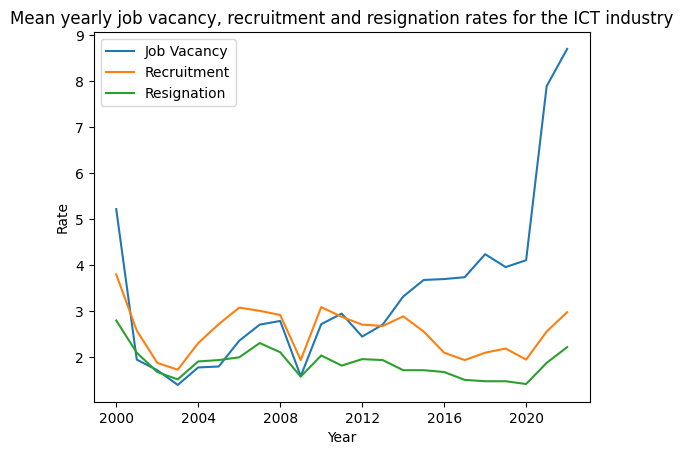

In [205]:
jobs.head(10)

jobs_mean = jobs[jobs['occupation1'] == 'total'][['year','job_vacancy_rate','recruitment_rate','resignation_rate']].groupby('year', as_index=False).mean().round(2)
jobs_mean['year'] = pd.to_datetime(jobs_mean['year'], format='%Y')

jobs_mean_melt = pd.melt(jobs_mean[['year','job_vacancy_rate','recruitment_rate','resignation_rate']], 
                            id_vars=['year'],
                            value_vars=['job_vacancy_rate','recruitment_rate','resignation_rate'],
                            value_name='rate')
jobs_mean_melt['variable'] = jobs_mean_melt['variable'].replace(['job_vacancy_rate','recruitment_rate','resignation_rate'], ['Job Vacancy','Recruitment','Resignation'])

f = sns.lineplot(jobs_mean_melt,x='year',y='rate',hue='variable')
f.set_ylabel('Rate')
f.set_xlabel('Year')
f.set_title('Mean yearly job vacancy, recruitment and resignation rates for the ICT industry')
f.legend(title='')

plt.show()

# ggplot(jobs_mean_melt,aes('year','rate', group='variable', color='variable'))+\
#     geom_line()+\
#     scale_y_continuous(breaks=range(0,10,1))+\
#     scale_x_date(date_breaks='2 year',date_labels='%Y')+\
#     labs(x="Year",y="Rate",title="Mean Yearly Job Vacancy, Recruitment and Resignation Rates for the ICT industy")+\
#     scale_color_discrete(name="Jobs")

/var/folders/nv/c05ywcr140z_fcwc2kx0h69m0000gn/T/ipykernel_6497/1098994829.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


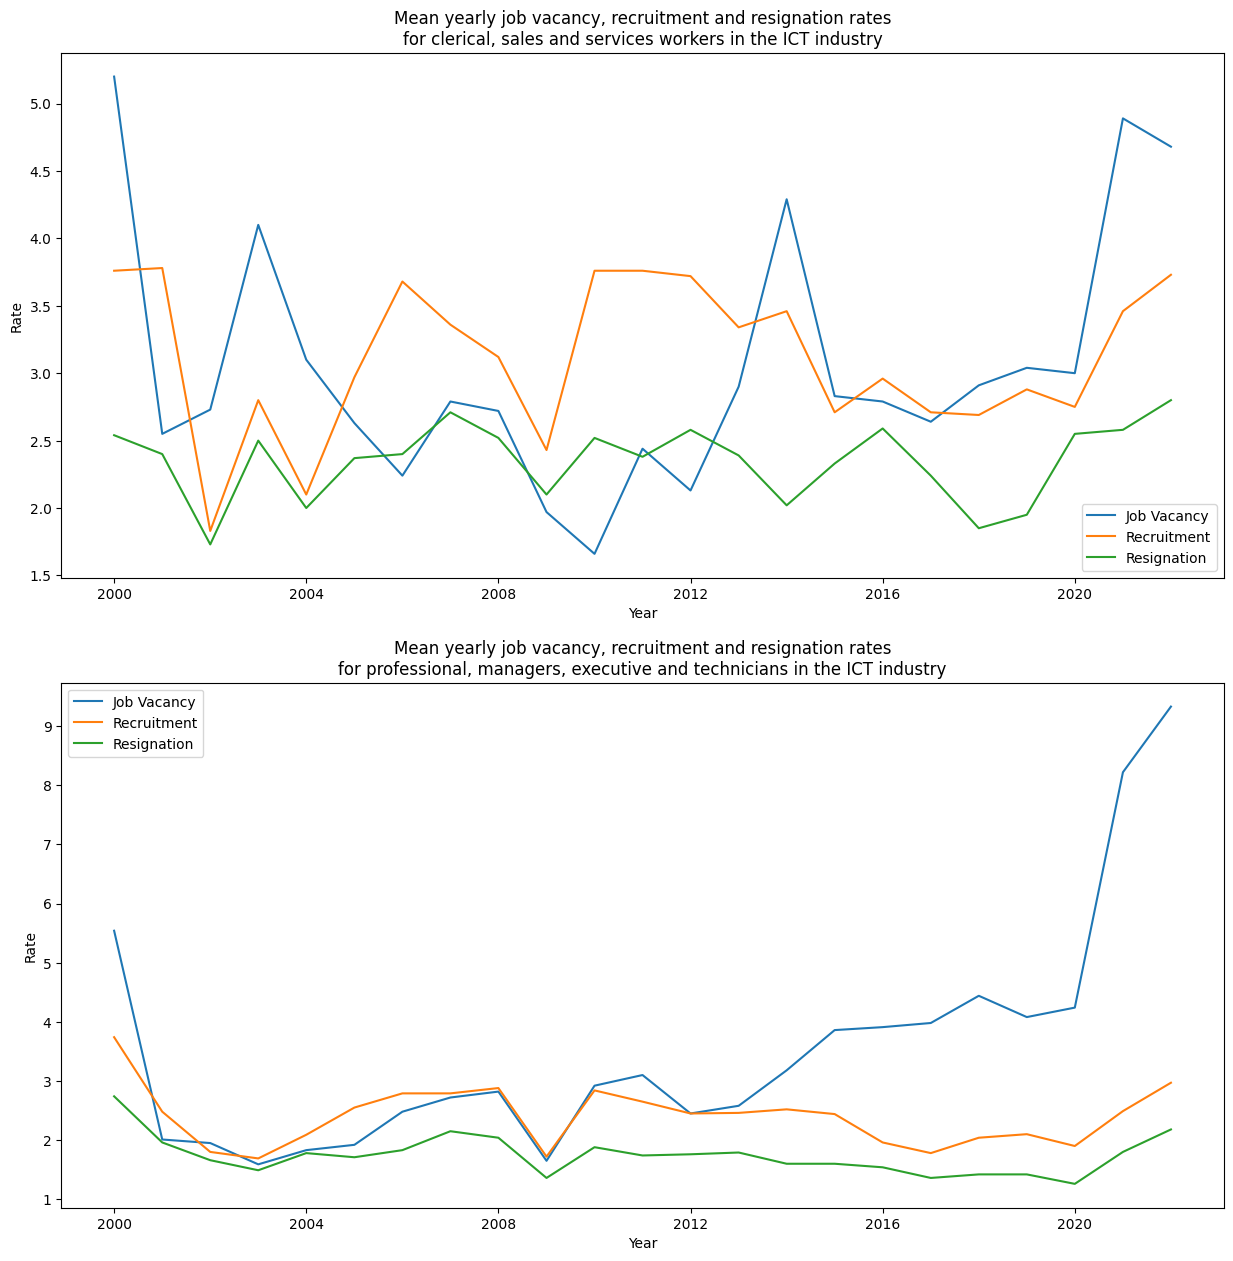

In [208]:
jobs.head(10)

jobtypes_mean = jobs[jobs['occupation1'] != 'total'].drop('job_vacancy',axis=1).groupby(['year','occupation1'], as_index=False).mean().round(2)
jobtypes_mean['year'] = pd.to_datetime(jobtypes_mean['year'], format='%Y')

jobtypes_mean_melt = pd.melt(jobtypes_mean, 
                            id_vars=['year','occupation1'],
                            value_vars=['job_vacancy_rate','recruitment_rate','resignation_rate'],
                            value_name='rate')
jobtypes_mean_melt['variable'] = jobtypes_mean_melt['variable'].replace(['job_vacancy_rate','recruitment_rate','resignation_rate'], ['Job Vacancy','Recruitment','Resignation'])

fig, axes = plt.subplots(2,1,figsize=(15,15))

sns.lineplot(ax=axes[0],data=jobtypes_mean_melt[jobtypes_mean_melt['occupation1']=='clerical, sales and services workers'],x='year',y='rate',hue='variable')
axes[0].set(title='Mean yearly job vacancy, recruitment and resignation rates\nfor clerical, sales and services workers in the ICT industry',
        xlabel='Year',
        ylabel='Rate')
axes[0].legend(title='')

sns.lineplot(ax=axes[1],data=jobtypes_mean_melt[jobtypes_mean_melt['occupation1']=='professional, managers, executive and technicians'],x='year',y='rate',hue='variable')
axes[1].set(title='Mean yearly job vacancy, recruitment and resignation rates\nfor professional, managers, executive and technicians in the ICT industry',
        xlabel='Year',
        ylabel='Rate')
axes[1].legend(title='')

# sns.lineplot(ax=axes[2],data=jobtypes_mean_melt[jobtypes_mean_melt['occupation1']=='production and transport operators, cleaners and labourers'],x='year',y='rate',hue='variable')
# axes[2].set(title='Mean yearly job vacancy, recruitment and resignation rates\nfor production and transport operators, cleaners and labourers in the ICT industry',
#         xlabel='Year',
#         ylabel='Rate')
# axes[2].legend(title='')

plt.show()

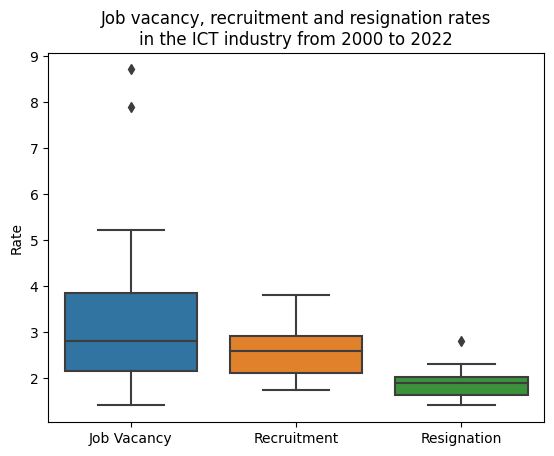

In [ ]:
a = sns.boxplot(x=jobs_mean_melt['variable'],y=jobs_mean_melt['rate'])
a.set(title='Job vacancy, recruitment and resignation rates\nin the ICT industry from 2000 to 2022',
        ylabel='Rate',
        xlabel='')

plt.show()

/var/folders/nv/c05ywcr140z_fcwc2kx0h69m0000gn/T/ipykernel_6497/2965092083.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


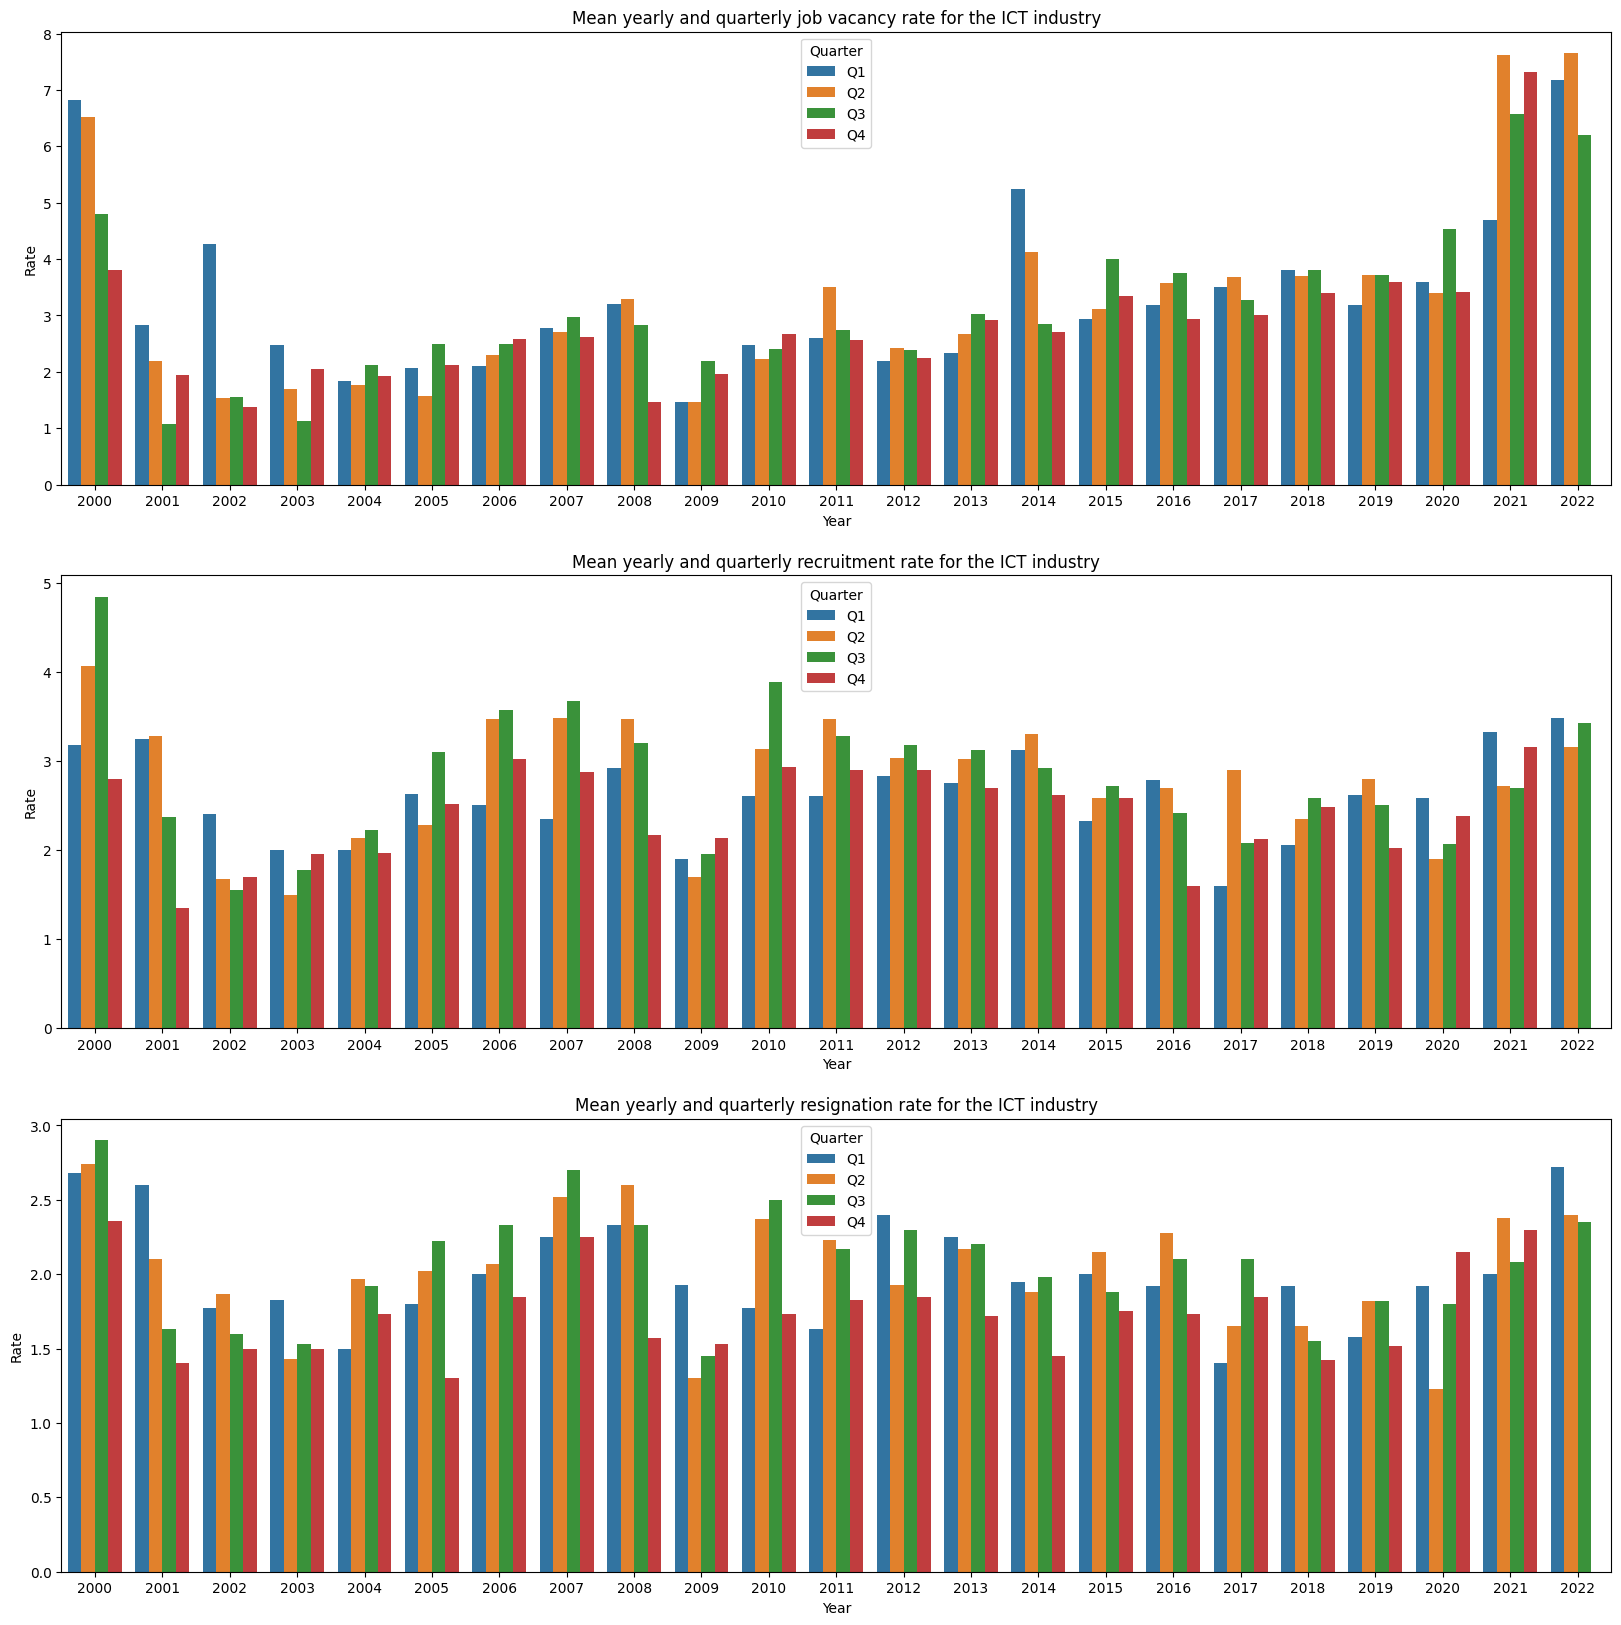

In [223]:
# dataframe of uni and poly intake and graduates joined with ICT vacancy, and recruitment numbers by years

jobs.head(10)

jobsmeanq = jobs[jobs['occupation1'] != 'total'].drop(['job_vacancy'],axis=1).groupby(['year','quarter'], as_index=False).mean().round(2)

jobsmeanq_melt = pd.melt(jobsmeanq, 
                            id_vars=['year','quarter'],
                            value_vars=['job_vacancy_rate','recruitment_rate','resignation_rate'],
                            value_name='rate')
jobsmeanq_melt['variable'] = jobsmeanq_melt['variable'].replace(['job_vacancy_rate','recruitment_rate','resignation_rate'], ['Job Vacancy','Recruitment','Resignation'])

fig, axes = plt.subplots(3,1, figsize=(20,20))

sns.barplot(ax=axes[0],data=jobsmeanq_melt[jobsmeanq_melt['variable']=='Job Vacancy'],x='year',y='rate',hue='quarter')
axes[0].set(ylabel='Rate',
        xlabel='Year',
        title='Mean yearly and quarterly job vacancy rate for the ICT industry')
axes[0].legend(title='Quarter')

sns.barplot(ax=axes[1],data=jobsmeanq_melt[jobsmeanq_melt['variable']=='Recruitment'],x='year',y='rate',hue='quarter')
axes[1].set(ylabel='Rate',
        xlabel='Year',
        title='Mean yearly and quarterly recruitment rate for the ICT industry')
axes[1].legend(title='Quarter')

sns.barplot(ax=axes[2],data=jobsmeanq_melt[jobsmeanq_melt['variable']=='Resignation'],x='year',y='rate',hue='quarter')
axes[2].set(ylabel='Rate',
        xlabel='Year',
        title='Mean yearly and quarterly resignation rate for the ICT industry')
axes[2].legend(title='Quarter')

plt.show()

/var/folders/nv/c05ywcr140z_fcwc2kx0h69m0000gn/T/ipykernel_6497/482711186.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


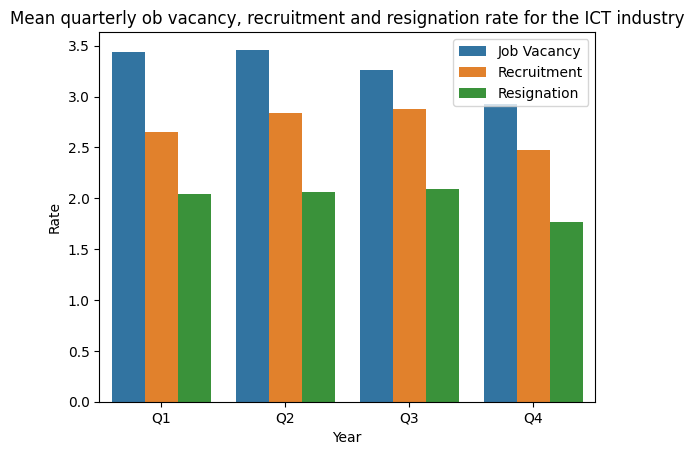

In [277]:
jobsmeanq = jobs[jobs['occupation1'] != 'total'].drop(['job_vacancy'],axis=1).groupby('quarter', as_index=False).mean().round(2)

jobsmeanq_melt = pd.melt(jobsmeanq, 
                            id_vars=['quarter'],
                            value_vars=['job_vacancy_rate','recruitment_rate','resignation_rate'],
                            value_name='rate')
jobsmeanq_melt['variable'] = jobsmeanq_melt['variable'].replace(['job_vacancy_rate','recruitment_rate','resignation_rate'], ['Job Vacancy','Recruitment','Resignation'])

p = sns.barplot(jobsmeanq_melt,x='quarter',y='rate',hue='variable')
p.set(ylabel='Rate',
        xlabel='Year',
        title='Mean quarterly ob vacancy, recruitment and resignation rate for the ICT industry')
p.legend(title='')

plt.show()

ShapiroResult(statistic=0.827965259552002, pvalue=2.8724845581567376e-14)
KstestResult(statistic=0.8261068003665271, pvalue=2.719079683439729e-154, statistic_location=1.2, statistic_sign=-1)


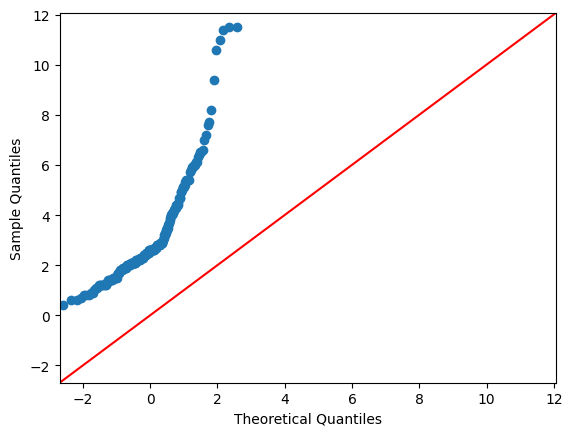

In [278]:
jobs_totals = jobs[jobs['occupation1']=='total']

print(shapiro(jobs_totals['job_vacancy_rate']))
print(kstest(jobs_totals['job_vacancy_rate'],'norm'))

fig = sm.qqplot(jobs_totals['job_vacancy_rate'],line='45')

#job vacancy rate data is not normal based on Q-Q plot!!

ShapiroResult(statistic=0.9736698269844055, pvalue=0.0007094149477779865)
KstestResult(statistic=0.8251182527791076, pvalue=9.224742896860054e-154, statistic_location=1.1, statistic_sign=-1)


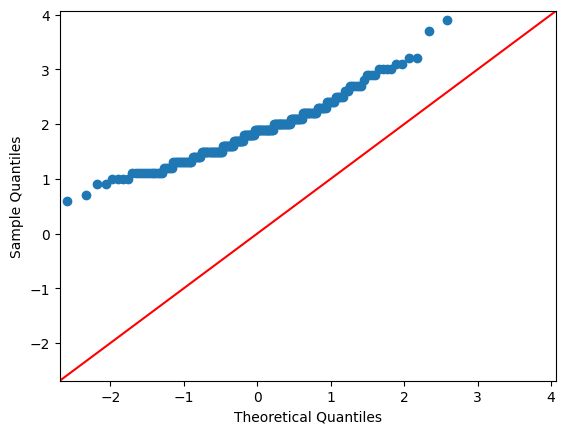

In [261]:
jobs_totals = jobs[jobs['occupation1']=='total']

print(shapiro(jobs_totals['resignation_rate']))
print(kstest(jobs_totals['resignation_rate'],'norm'))

fig = sm.qqplot(jobs_totals['resignation_rate'],line='45')

# resignation rate data is not normal based on shapiro-wilk test and Q-Q plot!!

ShapiroResult(statistic=0.9761932492256165, pvalue=0.0015444167656823993)
KstestResult(statistic=0.8447260959163624, pvalue=8.584256484011567e-165, statistic_location=1.1, statistic_sign=-1)


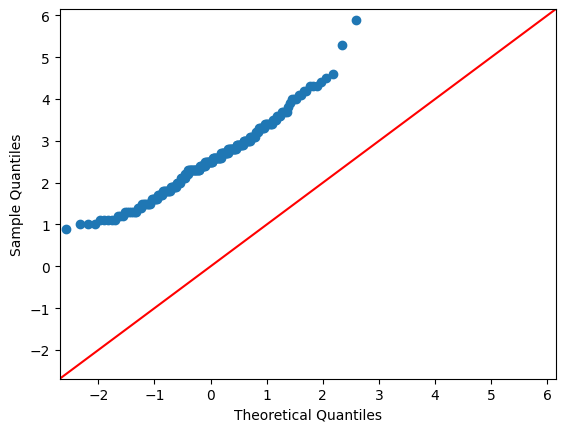

In [262]:
jobs_totals = jobs[jobs['occupation1']=='total']

print(shapiro(jobs_totals['recruitment_rate']))
print(kstest(jobs_totals['recruitment_rate'],'norm'))

fig = sm.qqplot(jobs_totals['recruitment_rate'],line='45')

# recruitment rate data is not normal based on shapiro-wilk test and Q-Q plot!!

In [276]:
pd.melt(jobs[jobs['occupation1'] == 'total'],
        id_vars=['year','quarter'],
        value_vars=['job_vacancy_rate','recruitment_rate','resignation_rate'],
        value_name='rate')

jobs_totals = jobs[jobs['occupation1']=='total']

quarter_vacancy = [jobs_totals.loc[ids, 'job_vacancy_rate'].values for ids in jobs_totals.groupby('quarter').groups.values()]
quarter_recruitment = [jobs_totals.loc[ids, 'recruitment_rate'].values for ids in jobs_totals.groupby('quarter').groups.values()]
quarter_resignation = [jobs_totals.loc[ids, 'resignation_rate'].values for ids in jobs_totals.groupby('quarter').groups.values()]

# non-parametric ANOVA for non-normal data
print(stats.kruskal(*quarter_vacancy))
print(stats.kruskal(*quarter_recruitment))
print(stats.kruskal(*quarter_resignation))
print()
# test for equality of variances
print(levene(*quarter_resignation))

# posthoc t-test for resignation_rate by quarter
sp.posthoc_scheffe(jobs_totals,val_col='resignation_rate',group_col='quarter')

KruskalResult(statistic=1.2964288733415554, pvalue=0.7299812499447278)
KruskalResult(statistic=6.824784163285945, pvalue=0.07769721869139162)
KruskalResult(statistic=10.922029732557506, pvalue=0.012155048775981319)

LeveneResult(statistic=0.0975465558774982, pvalue=0.9613106130799147)


,Q1,Q2,Q3,Q4
Q1,1.000000,0.699621,0.801514,0.307575
Q2,0.699621,1.000000,0.998014,0.024583
Q3,0.801514,0.998014,1.000000,0.040668
Q4,0.307575,0.024583,0.040668,1.000000


In [282]:
resignation_quarterly = jobs[jobs['occupation1'] != 'total'][['quarter','resignation_rate']].groupby('quarter', as_index=False).mean().round(2)
resignation_quarterly

s = sns.barplot(resignation_quarterly,
                x='quarter'
                y='resignation_rate')


,quarter,resignation_rate
0,Q1,2.04
1,Q2,2.06
2,Q3,2.09
3,Q4,1.77
